In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

Let's load the dataset from previos step - cleansed data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import zscore, ks_2samp

df_fe = pd.read_pickle("IntermidiateData/3_Final_Cancer_Data.pkl")

In [3]:
df_fe.head()
df_fe.shape

(569, 31)

# Label encoding


In [4]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
# Label encode the 'diagnosis' column
df_fe['diagnosis'] = label_encoder.fit_transform(df_fe['diagnosis'])
# Print the updated dataframe
display(df_fe.head(2))

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


From now and on , when target variable is numberic (mapped 1: malignant , 0: benign) - it can be used with various models for prediction and feature selection.     


The outliers were handled previously , and as we could see dropping existing outliers will not affect distribution / correlation to a target.  
Therefore there is no need for futher scaling or normalization of the data. In addition,  It seems that some of the features in dataset was already standartized (values between 0 and 1 , no negative values).

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt   

# def plot_jointplot(df, featurex, featurey , outcomename='diagnosis' , title = 'before transformation'):    
#     df_info = pd.DataFrame({ 'mean': [df[featurex].mean() , df[featurey].mean()],
#                              'std': [df[featurex].std() , df[featurey].std()]})
#     print(f'Comparision of {featurex} vs. {featurey} {title} ')
#     sns.jointplot(x=featurex, y=featurey, data=df, kind='reg', color='green',height=5)    
#     plt.show()
    
# plot_jointplot(df_fe , 'area_mean', 'radius_mean')



As seems in the above visualization, neither distribution correlation to a target did not change.


As seen in EDA notebook , there is data is balanced enougth (40% malignant and 60% benign) to use the data as is.

# Lets show that this dataset has good chances for classification , using unsuperwised learning

In [6]:
X = df_fe.drop('diagnosis', axis=1)
y = df_fe['diagnosis']

In [24]:
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score , roc_auc_score
from sklearn.metrics import recall_score, accuracy_score , confusion_matrix , precision_score , classification_report

unsupervised_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'Silhouette Score'])

def print_metrics(model, targs, preds):
        print(f'Confusion matrix for {model}]:')
        display(pd.crosstab(targs, preds ,rownames=['Pred'], colnames=['Actual'], margins=True, margins_name="Total"))  
        model_name = type(model).__name__        
        unsupervised_metrics_df.loc[model_name] = [accuracy_score(targs, preds), precision_score(targs, preds), recall_score(targs, preds), f1_score(targs, preds), roc_auc_score(targs, preds), silhouette_score(pd.DataFrame(targs), preds)]
        #print(classification_report(targs, preds))


def plot_kmeans(df, feature1, feature2, model):
    # Plot the KMeans clustering
    plt.figure(figsize=(10, 6))
    plt.scatter(df[feature1], df[feature2], c=model.labels_, cmap='viridis')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red', marker='x')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'KMeans clustering')
    plt.show()


Lets start with a simple KMeans clustering model

<Axes: title={'center': 'KMeans clustering for radius_mean vs. fractal_dimension_mean'}, xlabel='radius_mean', ylabel='fractal_dimension_mean'>

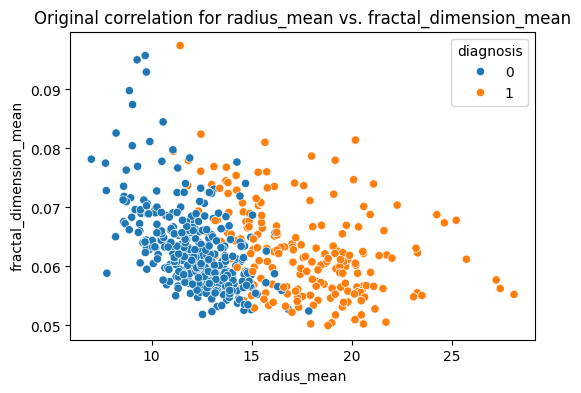

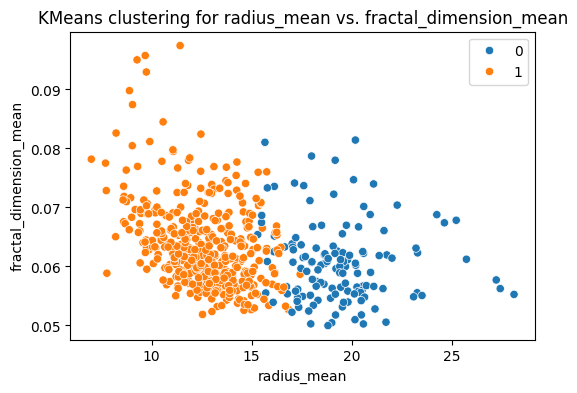

In [8]:
# ==============================================================================
kmodel = KMeans(n_clusters=2, random_state=1).fit(X)    
labels = kmodel.predict(X)    

# ==============================================================================
# plot Original correlation for radius_mean vs. fractal_dimension_mean'
fig, axs=plt.subplots(1,1,figsize=(6,4))
axs.set_title('Original correlation for radius_mean vs. fractal_dimension_mean')
sns.scatterplot(x=df_fe['radius_mean'], y=df_fe['fractal_dimension_mean'],hue=df_fe['diagnosis'], ax=axs)

# plot kmeans  
fig, axs=plt.subplots(1,1,figsize=(6,4))    
axs.set_title('KMeans clustering for radius_mean vs. fractal_dimension_mean')
sns.scatterplot(x=X['radius_mean'], y=X['fractal_dimension_mean'],hue=kmodel.labels_, ax=axs)


In [25]:
print_metrics(kmodel, y , labels)

Confusion matrix for KMeans(n_clusters=2, random_state=1)]:


Actual,0,1,Total
Pred,,,
0,13,344,357
1,184,28,212
Total,197,372,569


Looks like clusters are transposed, but althought if so , 
we can see here that kmeans was good at identification of benign cases (356 out of 357) but not good enough identificating (separating) malignancy (130 of 212 - about 60% accuracy ) ,which is bad , especially in medical predictions.
Total accuracy , precision , recall and rest of metrics are quite low. 


Lets try OneClassSVM which also can be used for unsuperwised learning , and GaussianMixture as well

In [26]:
from sklearn.svm import OneClassSVM
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.mixture import GaussianMixture as gaussianMixture


target_values = df_fe['diagnosis'].value_counts() 
target_values = pd.Series(target_values)
target_values = pd.DataFrame(target_values)
target_values.reset_index(inplace = True)
target_values.index = ['Benign', 'Malignant']
print('Percentages and counts of the target values:')
display(target_values)

# ==============================================================================
# First need to do a data one-class to use one-class SVM for unsupervised learning
one_class_target = y
one_class_target = one_class_target.replace({0: 1, 1: -1})
# find the proportion of outliers we expect (aka where `diagnosis == -1`) in the data
# and use that to set the `nu` hyperparameter
outliers = one_class_target[one_class_target == -1]
nu = outliers.shape[0] / one_class_target.shape[0]
print(f"nu: {nu}")

#==============================================================================
svm = OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)
svm.fit(X)
labels = svm.predict(X)
print_metrics(svm, labels, one_class_target)

#==============================================================================
gaussianm = gaussianMixture(n_components=2, random_state=1).fit(X)
labels = gaussianm.predict(X)
print_metrics(gaussianm, labels, y)

display(unsupervised_metrics_df.sort_values(by='Silhouette Score', ascending=False))



Percentages and counts of the target values:


,diagnosis,count
Benign,0,357
Malignant,1,212


nu: 0.37258347978910367
Confusion matrix for OneClassSVM(gamma=5e-05, nu=0.37258347978910367)]:


Actual,-1,1,Total
Pred,,,
-1,157,55,212
1,55,302,357
Total,212,357,569


Confusion matrix for GaussianMixture(n_components=2, random_state=1)]:


Actual,0,1,Total
Pred,,,
0,13,184,197
1,344,28,372
Total,357,212,569


,Accuracy,Precision,Recall,F1,AUC,Silhouette Score
GaussianMixture,0.072056,0.132075,0.075269,0.095890,0.070629,0.791095
KMeans,0.072056,0.075269,0.132075,0.095890,0.084245,0.789176
OneClassSVM,0.806678,0.845938,0.845938,0.845938,0.793252,0.467186


The scores of one-class SVM are better than KMeans clustering , and GaussianMixture model brings ever better scores.
This is enough to see there are good chances to develop a high-presicion classification by diagnosis model on this dataset

# Hyperparameters

## Feature Selection 

### Univariable Feature Selection

We can use here t-tests because it examines relationship between a continuous feature and a binary outcome.

In [11]:
import scipy.stats as stats

def t_test_groups(group1, group2, timing= 'before transformation'):
    # Perform an independent samples t-test
    t_test_results = pd.DataFrame(columns=['T-Statistic', 'P-Value'])
    for col in group1: # columns will be the same in both groups; 'diagnosis' column is dropped
        t_stat, p_value = stats.ttest_ind(group1[col], group2[col])
        t_test_results.loc[col] = [t_stat, p_value]
            
    len = t_test_results[t_test_results['P-Value']>0.05].shape[0]
    print(f'Out of all features , for the follow {len} features the difference between the two groups is not statistically significant')
    unsignificant_diff_columns = t_test_results[t_test_results['P-Value']>0.05].index
    display(t_test_results[t_test_results['P-Value']>0.05].sort_values(by='P-Value'))
    return unsignificant_diff_columns

# Perform a t-test after transformation to see if the difference between the two groups (by diagnosis) is statistically significant
# If the p-value is greater than 0.05, we can drop the feature
malignant = df_fe[df_fe['diagnosis'] == 1].drop('diagnosis', axis=1)
benign = df_fe[df_fe['diagnosis'] == 0].drop('diagnosis', axis=1)
unsignificant_diff_columns = t_test_groups(malignant, benign, timing= 'after transformation')
# Features returned by the t-test as not having a statistically significant difference between the two groups so we can drop it
df_fe.drop(unsignificant_diff_columns, axis=1, inplace=True)    
display(df_fe.shape)
X = df_fe.drop('diagnosis', axis=1)
y = df_fe['diagnosis']

Out of all features , for the follow 5 features the difference between the two groups is not statistically significant


,T-Statistic,P-Value
fractal_dimension_se,1.862330,0.063074
smoothness_se,-1.599365,0.110297
fractal_dimension_mean,-0.305711,0.759937
texture_se,-0.197724,0.843332
symmetry_se,-0.155298,0.876642


(569, 26)

Now lets use the K-best to Select features according to the k highest scores , out of the remaining 26 features.        
This is why those will be dropped

In [12]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2 , f_classif , f_regression

def univariate_kbest(score_func, num_features):
    # Apply SelectKBest class to extract top 10 best features with Chi-Square tests
    feature_score  = SelectKBest(score_func, k=10).fit(X, y)
    cols = pd.DataFrame(feature_score.scores_ , columns=['Feature_Scores'])
    cols['Feature_Names'] = X.columns
    df_univatiate = cols.nlargest(num_features,'Feature_Scores')
    df_univatiate_columns = df_univatiate.Feature_Names.to_list()
    display(df_univatiate_columns)
    return df_univatiate_columns


n_features = 15
# Apply SelectKBest class to extract top 10 best features with Chi-Square tests
chi2_list = univariate_kbest(chi2, n_features)
# A-Nova
anova_list = univariate_kbest(f_classif, n_features)
# Linear Regression -  returning F-statistic and p-values
lr_list = univariate_kbest(f_regression, n_features)




['area_worst',
 'area_mean',
 'area_se',
 'perimeter_worst',
 'perimeter_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_se',
 'texture_worst',
 'texture_mean',
 'concavity_worst',
 'radius_se',
 'concavity_mean',
 'compactness_worst',
 'concave points_worst']

['concave points_worst',
 'perimeter_worst',
 'concave points_mean',
 'radius_worst',
 'perimeter_mean',
 'area_worst',
 'radius_mean',
 'area_mean',
 'concavity_mean',
 'concavity_worst',
 'compactness_mean',
 'compactness_worst',
 'radius_se',
 'perimeter_se',
 'area_se']

['concave points_worst',
 'perimeter_worst',
 'concave points_mean',
 'radius_worst',
 'perimeter_mean',
 'area_worst',
 'radius_mean',
 'area_mean',
 'concavity_mean',
 'concavity_worst',
 'compactness_mean',
 'compactness_worst',
 'radius_se',
 'perimeter_se',
 'area_se']

### Multivariable Analysis

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier ,AdaBoostRegressor
from sklearn.linear_model import Lasso , Ridge , RidgeClassifierCV , RidgeClassifier , LogisticRegression , LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC


In [14]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

ridge = Ridge(alpha=0.5).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

lreg = LogisticRegression(max_iter=1000, C=1, penalty='l1', solver='liblinear').fit(X, y)
lreg_selected = (np.abs(lreg.coef_[0]) > 0).astype(int)

linearReg = LinearRegression().fit(X, y)
linearReg_selected = (np.abs(linearReg.coef_) > 0).astype(int)

gb = GradientBoostingClassifier().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

adb = AdaBoostRegressor().fit(X, y)
adb_selected = (adb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'Ridge': ridge_selected,
    'SVM': svm_selected,
    'LinearReg': linearReg_selected,
    'GradientBoost': gb_selected,
    'AdaBoost': adb_selected,
    'RandomForest': rf_selected,
    'LogisticRegression': lreg_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'Ridge', 'SVM', 'LinearReg', 'GradientBoost',  'AdaBoost' , 'RandomForest','LogisticRegression']].sum(axis=1)


As see above , most of the models cannot properly decide on feature importance , maybe because of a higth multicollinearity in dataset  (high corellations between different features) .

In [15]:

# Output the results
display(selection_df)

,Feature,Lasso,Ridge,SVM,LinearReg,GradientBoost,AdaBoost,RandomForest,LogisticRegression,Sum
0,radius_mean,0,1,0,1,1,1,1,1,6
1,texture_mean,1,1,0,1,1,1,1,0,6
2,perimeter_mean,0,1,1,1,1,1,1,1,7
3,area_mean,1,1,1,1,1,1,1,1,8
4,smoothness_mean,0,1,0,1,1,1,1,0,5
5,compactness_mean,0,1,0,1,1,1,1,0,5
6,concavity_mean,0,1,0,1,1,1,1,0,5
7,concave points_mean,0,1,0,1,1,1,1,0,5
8,symmetry_mean,0,1,0,1,1,1,1,0,5
9,radius_se,0,1,0,1,1,1,1,0,5


In [16]:
#Selecting variables with a sum of selections >= 6
final_var = selection_df[selection_df['Sum'] >= 5  ]['Feature'].tolist()
df_model = df_fe[final_var].copy()
df_model['diagnosis'] = df_fe['diagnosis'].copy()

columns_list = df_model.columns.tolist()
display(f"Most important features of the dataset : {len(columns_list)}")
display(f"{columns_list}")
display(df_model.head(2))
display(df_model.shape)

# df_model.correlation = df_model.corr()
# heatmap = sns.heatmap(df_model.corr(), annot=True, cmap='summer', fmt=".2f")  
# plt.title('Correlation Heatmap')
# plt.show()
# #display(df_model.correlation)


'Most important features of the dataset : 26'

"['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'diagnosis']"

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,radius_se,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1


(569, 26)

In [17]:
# Compare results from univariate and model-based feature selection
chi2_univatiate_columns_set = set(chi2_list)
anova_univatiate_columns_set = set(anova_list)
lr_univatiate_columns_set = set(lr_list)
multivatiate_columns_set = set(df_model.columns.tolist())

def interception_set(set1, set2 , name1, name2):
    interception_set = set1.intersection(set2)
    display(f"Common columns between univariate {name1} and model-based feature selection:")
    display(f"Features : {interception_set} ")
    display(f"Length : {interception_set.__len__()}")
    return interception_set , interception_set.__len__()


dict_choosen_columns = {}

list1, len1 = interception_set(chi2_univatiate_columns_set, multivatiate_columns_set, name1='chi2_univatiate_columns_set', name2='multivatiate_columns_set')
list2, len2 = interception_set(anova_univatiate_columns_set, multivatiate_columns_set, name1='anova_univatiate_columns_set', name2='multivatiate_columns_set')
list3, len3 = interception_set(lr_univatiate_columns_set, multivatiate_columns_set, name1='lr_univatiate_columns_set', name2='multivatiate_columns_set')
display(multivatiate_columns_set)
display(len(multivatiate_columns_set))
display(f"multivatiate_columns_set:")
display(f"Features : {multivatiate_columns_set} ")
display(f"Length : {multivatiate_columns_set.__len__()}")



list1 = list(list1)
display(f"List1 : {list1} len1 {len1}")

X = df_fe[list1]
y = df_fe['diagnosis']
display(X.head(2))
display(y.head(2))
display(X.shape)
# We'll choose the features that are common to all three sets - chi2, anova, lr  and multivariate - and this is most close 
# to the ch2 list with 15 features


'Common columns between univariate chi2_univatiate_columns_set and model-based feature selection:'

"Features : {'area_se', 'concave points_worst', 'radius_mean', 'texture_worst', 'compactness_worst', 'perimeter_mean', 'texture_mean', 'perimeter_worst', 'area_mean', 'radius_worst', 'concavity_worst', 'radius_se', 'concavity_mean', 'perimeter_se', 'area_worst'} "

'Length : 15'

'Common columns between univariate anova_univatiate_columns_set and model-based feature selection:'

"Features : {'concave points_worst', 'area_se', 'compactness_mean', 'radius_mean', 'concavity_mean', 'compactness_worst', 'perimeter_mean', 'perimeter_worst', 'area_mean', 'radius_worst', 'concavity_worst', 'radius_se', 'concave points_mean', 'perimeter_se', 'area_worst'} "

'Length : 15'

'Common columns between univariate lr_univatiate_columns_set and model-based feature selection:'

"Features : {'concave points_worst', 'area_se', 'compactness_mean', 'radius_mean', 'concavity_mean', 'compactness_worst', 'perimeter_mean', 'perimeter_worst', 'area_mean', 'radius_worst', 'concavity_worst', 'radius_se', 'concave points_mean', 'perimeter_se', 'area_worst'} "

'Length : 15'

{'area_mean',
 'area_se',
 'area_worst',
 'compactness_mean',
 'compactness_se',
 'compactness_worst',
 'concave points_mean',
 'concave points_se',
 'concave points_worst',
 'concavity_mean',
 'concavity_se',
 'concavity_worst',
 'diagnosis',
 'fractal_dimension_worst',
 'perimeter_mean',
 'perimeter_se',
 'perimeter_worst',
 'radius_mean',
 'radius_se',
 'radius_worst',
 'smoothness_mean',
 'smoothness_worst',
 'symmetry_mean',
 'symmetry_worst',
 'texture_mean',
 'texture_worst'}

26

'multivatiate_columns_set:'

"Features : {'radius_mean', 'fractal_dimension_worst', 'compactness_worst', 'compactness_se', 'concavity_worst', 'smoothness_worst', 'perimeter_worst', 'concavity_mean', 'perimeter_se', 'concavity_se', 'concave points_mean', 'area_se', 'compactness_mean', 'texture_worst', 'symmetry_worst', 'area_worst', 'diagnosis', 'area_mean', 'perimeter_mean', 'concave points_worst', 'concave points_se', 'texture_mean', 'smoothness_mean', 'radius_worst', 'symmetry_mean', 'radius_se'} "

'Length : 26'

"List1 : ['area_se', 'concave points_worst', 'radius_mean', 'texture_worst', 'compactness_worst', 'perimeter_mean', 'texture_mean', 'perimeter_worst', 'area_mean', 'radius_worst', 'concavity_worst', 'radius_se', 'concavity_mean', 'perimeter_se', 'area_worst'] len1 15"

,area_se,concave points_worst,radius_mean,texture_worst,compactness_worst,perimeter_mean,texture_mean,perimeter_worst,area_mean,radius_worst,concavity_worst,radius_se,concavity_mean,perimeter_se,area_worst
0,153.40,0.2654,17.99,17.33,0.6656,122.8,10.38,184.6,1001.0,25.38,0.7119,1.0950,0.3001,8.589,2019.0
1,74.08,0.1860,20.57,23.41,0.1866,132.9,17.77,158.8,1326.0,24.99,0.2416,0.5435,0.0869,3.398,1956.0


0    1
1    1
Name: diagnosis, dtype: int64

(569, 15)

### Dimensionality reduction with PCA
According to the correlations matrix , the problem of multicollinearity is still here , as out of 15 selected features (each got at least 5 common votes as important one) - there are still many features  with high correlations.
Rather than dropping some of the high-correlating features , we can use PCA - which will engeneer a few new features (components) which include most of the data variablity found in the dataset.

(15, 15)
Eigen values:
 [1.00505213e+01 1.94405395e+00 1.47374656e+00 9.40082927e-01
 1.90710995e-01 1.11369493e-01 1.00513370e-01 5.69775327e-02
 5.17672449e-02 4.24334092e-02 2.35881295e-02 1.09141229e-02
 1.93922022e-03 1.13471082e-03 2.47027033e-04]
Eigen values Shape: (15,)
Eigen Vector Shape: (15, 15)
3


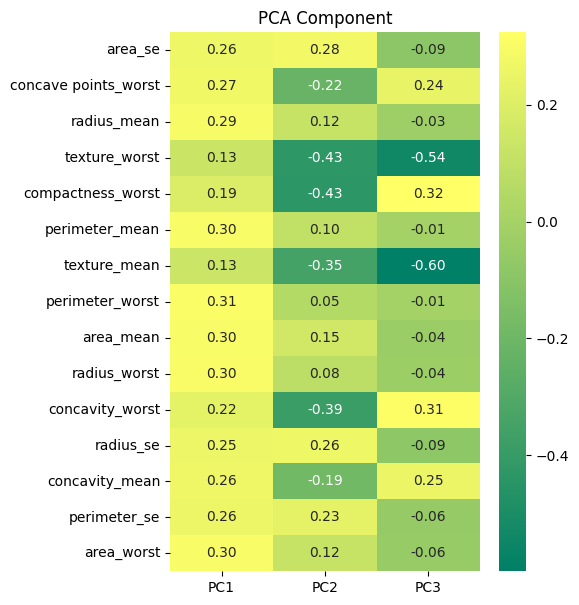

In [18]:
from sklearn.decomposition import PCA

# PCA is sensitive to the scale of the data. Therefore, we need to standardize the data before applying PCA.
X_mean = X.mean()
# Standard deviation
X_std = X.std()
# Standardization
Z = (X - X_mean) / X_std
# covariance
c = Z.cov()
print(c.shape)

# # Plot the covariance matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize =(8, 7))
# sns.heatmap(c, cmap='summer' , fmt=".2f")
# plt.title('Covariance Matrix of standartized data')
# plt.show()

#compute the eigenvectors and eigenvalues for our features , this is important for identifying the principal components for our feature space.
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

# Sort the eigenvalues in descending order and sort the corresponding eigenvectors accordingly.
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]
# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]
# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]
# the amount of the total variance which has been retained by selecting the principal components instead of the original feature space.
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

#considering explained variance more than equal to 80%. 
# Let’s check how many principal components come into this.
n_components = np.argmax(explained_var >= 0.80) + 1
print(n_components)
columns = ['PC'+str(i) for i in range(1,n_components+1)]

# PCA component or unit matrix
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
                             index = X.columns,
                             columns = columns
                            )

# plotting heatmap
pca_component.shape
pca_component.head(2)
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component, annot=True, cmap='summer', fmt=".2f")
plt.title('PCA Component')
plt.show()




Here from the plot we can see that two PCA components can explain up to 0.7 of data variance in dataset , so that the multicollinearity problem should be corrected.

          PC1       PC2       PC3
0    6.704514  1.270795 -3.818683
1    3.643602  1.816435 -0.031304
2    4.876675  0.154797 -0.642165
3    1.468997 -3.742649 -2.743253
4    3.993635  2.457778 -1.535294
..        ...       ...       ...
564  6.791521  2.129333  0.474791
565  4.703842  0.142316  2.631662
566  1.935777 -1.162498  1.783372
567  7.920882 -3.763795 -0.444807
568 -3.859675 -0.239735  2.344803

[569 rows x 3 columns]
 explained_variance_ratio_: [0.67003475 0.1296036  0.09824977]
 total explained_variance_ratio_: 0.8978881211854567
 total components : 3


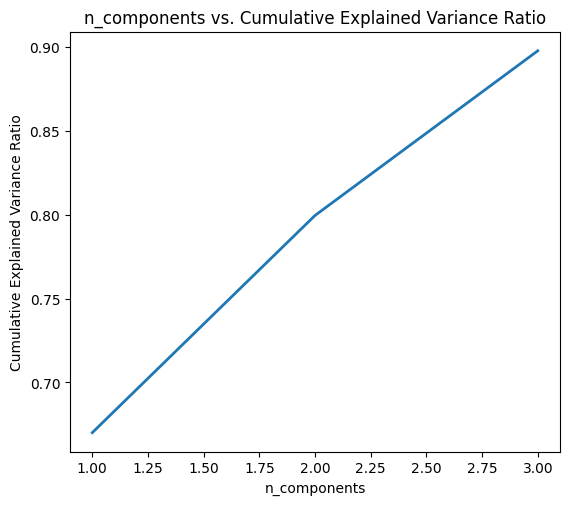

In [19]:
# Same using sklearn
pca = PCA(n_components=n_components)
pca.fit(Z)
x_pca = pca.transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
                       columns=['PC{}'.
                       format(i+1)
                        for i in range(n_components)])
print(df_pca1)

print(f" explained_variance_ratio_: {pca.explained_variance_ratio_}")
transformed_pca = pca.transform(X)
print(f" total explained_variance_ratio_: {sum(pca.explained_variance_ratio_)}")
print(f" total components : {pca.components_.shape[0]}")

plt.figure(2, figsize=(7, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(range(1, pca.components_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('n_components vs. Cumulative Explained Variance Ratio')
plt.show()

# Save to a pkl - feature engeneering 

In [20]:


df_model = X.copy()
df_model['diagnosis'] = y.copy()
#print(df_model.tail(2))
print(df_model.shape)
#sns.heatmap(df_model.corr(), annot=True, cmap='summer', fmt=".2f")
df_model.to_pickle('IntermidiateData/4_FeatureEngeneering_Cancer_Data.pkl')

(569, 16)
